### Own probability calculator

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
import sys
from scipy import stats
from scipy.stats import binom, poisson, norm
from iminuit import Minuit
from sympy.tensor.array import derive_by_array
from numpy import identity, array, dot, matmul
from latex2sympy2 import latex2sympy
from sympy import *
from matplotlib import cm, colors
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.append('C:\\Users\\Bruger\\AppStat2021\\External_Functions')
import Clotilde_external_functions as cef
import ExternalFunctions as ef
from ExternalFunctions import nice_string_output, add_text_to_ax, UnbinnedLH

plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

In [4]:
def calcPathLength(cz,r=6371.,h=15.,d=1.) :
    '''
    cz = cos(zenith) in radians, to be converted to path length in km
    r = Radius of Earth, in km
    h = Production height in atmosphere, in km
    d = Depth of detector, in km
    '''
    return -r*cz +  np.sqrt( (r*cz)**2 - r**2 + (r+h+d)**2 )

In [5]:
def prob_numu_numu(theta23, DM32):
    
    
    eBins = 200
    #eList = np.linspace(1, 100, eBins)  # GeV
    eList = np.logspace(0,2, eBins)
    
    n_theta = 200
    cos_theta = np.linspace(-1, 1, n_theta)

    # parameters from //www.nu-fit.org/?q=node/238. We use the approximation DM31 = DM32
    #DM21   = 7.60e-5   #eV
    theta13 =  8.62/180 * np.pi #np.arcsin(np.sqrt(0.025))/np.pi*180.
    theta12 = 33.45/180 * np.pi  #np.arcsin(np.sqrt(0.312))/np.pi*180. 
    
        
    L = calcPathLength(cos_theta) # km
    prob = 1 - 4*np.sin(theta23)**2 *np.cos(theta13)**2 *(1 - np.sin(theta23)**2 *np.cos(theta13)**2) \
    *np.sin(-1.27 * DM32 * L[np.newaxis,:].T /eList)**2
    
    
    return prob

In [6]:
theta23_true = 42.1/180*np.pi 
DM32_true = 2.51e-3   #eV

prob = prob_numu_numu(theta23_true, DM32_true);

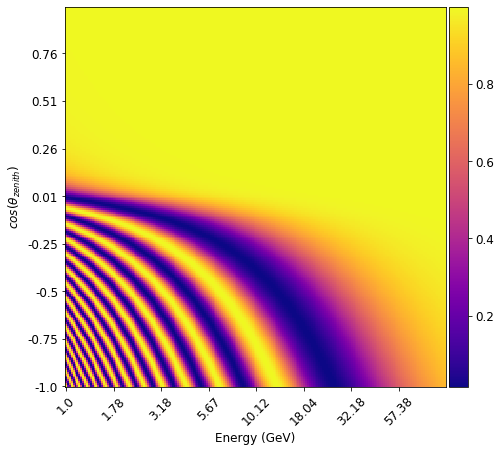

In [8]:
#eList = np.linspace(1, 100, 200)
eList = np.logspace(0, 2, 200)
cos_theta = np.linspace(-1, 1, 200)

fig, ax = plt.subplots(figsize=(10,7))

im = ax.imshow(prob, cmap='plasma', norm = None, origin = 'lower')  #[:,0:200]
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel(r'$cos(\theta_{zenith})$')
ax.set_xticks(np.arange(0, 180, 25))
ax.set_xticklabels([f'{np.round(eList[i],2)}' for i in np.arange(0, 180, 25)], rotation=45)
ax.set_yticks(np.arange(0, 180, 25))
ax.set_yticklabels([f'{np.round(cos_theta[i],2)}' for i in np.arange(0, 180, 25)])
#fig.savefig('Oscprob_own');

In [143]:

# cos intervals for binning
cos_intervals = np.round(np.arange(1, -1, -0.1), 2)
cos_bins = np.digitize(cos_theta, cos_intervals, right=True)                                
    
# energy intervals
energy_min = np.genfromtxt('numu_cc.csv', skip_header = 1, delimiter =',')[:,0]
energy_max = np.genfromtxt('numu_cc.csv', skip_header = 1, delimiter =',')[:,1]
energy_bins = np.digitize(eList, energy_min)
energy_binwidths = energy_max - energy_min

# Labels 

xticks = np.arange(-0.5, 10.5, 1)
energy_ticklabels = np.append(energy_min, energy_max[-1])
energy_strings = [f'{energy_ticklabels[i]}' for i in range(len(xticks))]

cos_values = np.round(np.arange(1, -1.1, -0.1), 2)
yticks = np.arange(-0.5, 20, 1)
ylabels = [f'{cos_values[i]}' for i in range(len(yticks))]

In [146]:
def bin_matrix(matrix, make_plot = False, savefig = None):
    
    #Binning
    matrix_ybinned = np.zeros((len(cos_intervals) , len(matrix[0])))

    # averaging rows in same interval
    for i in range(1, len(cos_intervals)+1):
        rows = np.where(cos_bins == i)[0]
        averaged_row = np.mean(matrix[rows[0] : rows[-1]+1, : ], axis = 0)
        matrix_ybinned[ i-1 , : ] = averaged_row
    
    binned_matrix = np.zeros((len(cos_intervals), len(energy_min)))  

    # averaging columns in same interval
    for i in range(1, len(energy_min)+1):
        columns = np.where(energy_bins == i)[0]
        averaged_column = np.mean(matrix_ybinned[ : , columns[0] : columns[-1]+1], axis = 1)
        binned_matrix[ : , i-1 ] = averaged_column
        
    if make_plot == True:
        fig, ax = plt.subplots(figsize=(10,7))

        im = ax.imshow(binned_matrix, cmap='plasma')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        cbar = plt.colorbar(im, cax=cax)
        ax.set_xlabel('Energy (GeV)')
        ax.set_ylabel(r'$cos(\theta_{zenith})$')
        ax.set_xticks(xticks)
        ax.set_xticklabels(energy_strings, rotation = 45)
        ax.set_yticks(yticks)
        ax.set_yticklabels(ylabels)
        cbar_label = r'$P(\nu_{\mu} \rightarrow \nu_{\mu})$'
        cbar.set_label(cbar_label)
        
        if savefig != None:
            fig.savefig(savefig)
        
    return binned_matrix

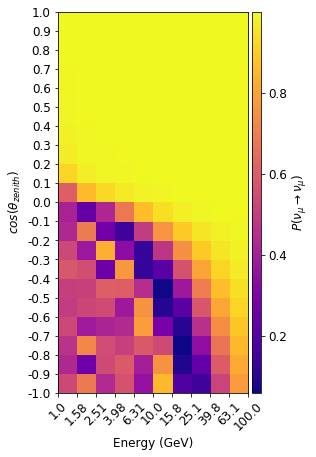

In [147]:
bin_matrix(prob, make_plot=True);